In [ ]:
# ライブラリのインストール
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 37.7 MB/s eta 0:00:00


自転車の現在地とホームポジションデータをランダムに生成

In [ ]:
import pandas as pd
import numpy as np

# シード値を設定
np.random.seed(4)

# 自転車の位置情報をランダムに生成
num_positions = 5  # 5個の位置情報を生成
min_coord, max_coord = 0, 100  # 座標の範囲（0から100）
home_positions = [(np.random.randint(min_coord, max_coord), np.random.randint(min_coord, max_coord)) for _ in range(num_positions)]

# 現在地情報（座標）をランダムに生成
current_locations = [(np.random.randint(min_coord, max_coord), np.random.randint(min_coord, max_coord)) for _ in range(num_positions)]

# データフレームを作成
bike_data = {
    'Home Position': home_positions,
    'Current Location': current_locations
}

df_bikes = pd.DataFrame(bike_data)

# Current Location == Home Positionの場合のデータを追加
num_same_positions = 5
same_locations =[(np.random.randint(min_coord, max_coord), np.random.randint(min_coord, max_coord)) for _ in range(num_same_positions)]
new_row = pd.DataFrame({'Home Position': same_locations, 'Current Location': same_locations})
df_bikes = pd.concat([df_bikes, new_row], ignore_index=True)

df_bikes

,Home Position,Current Location
0,"(46, 55)","(55, 55)"
1,"(69, 1)","(57, 36)"
2,"(87, 72)","(50, 44)"
3,"(50, 9)","(38, 52)"
4,"(58, 94)","(3, 0)"
5,"(55, 21)","(55, 21)"
6,"(21, 73)","(21, 73)"
7,"(38, 56)","(38, 56)"
8,"(66, 46)","(66, 46)"
9,"(30, 8)","(30, 8)"


ユーザー情報を別のデータフレームとして保持

In [ ]:
user_data = {
    'User': ['User 1', 'User 2'],
    'Current Position': [(58, 45), (70, 50)],
    'Destination': [(80, 80), (70, 70)]
}

df_users = pd.DataFrame(user_data)
df_users

,User,Current Position,Destination
0,User 1,"(58, 45)","(80, 80)"
1,User 2,"(70, 50)","(70, 70)"


以下の二種類の情報をプロットする
- 自転車の現在地とホームポジションまでの方向
- ユーザーの現在地と目的地までの方向

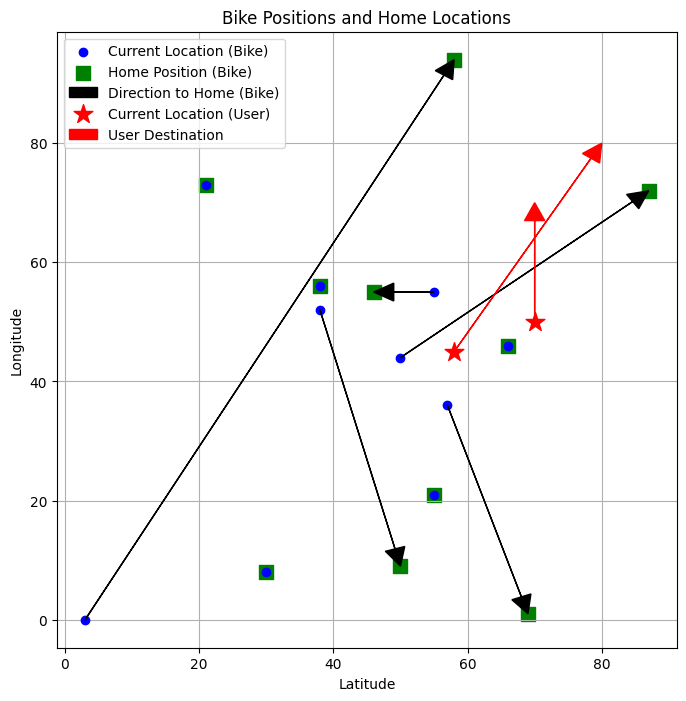

In [ ]:
import matplotlib.pyplot as plt

# プロットを作成
plt.figure(figsize=(8, 8))

# 自転車と自宅位置のプロット
for index, row in df_bikes.iterrows():
    # 現在地をプロット
    plt.scatter(row['Current Location'][0], row['Current Location'][1],
                marker='o', color='blue', zorder=2,
                label="Current Location (Bike)" if index == 0 else "")
    # 自宅位置をプロット
    plt.scatter(row['Home Position'][0], row['Home Position'][1],
                marker='s', color='green', s=100, zorder=1,
                label="Home Position (Bike)" if index == 0 else "")
    # 矢印をプロット
    # 見やすさの観点から矢印の長さを短くしてプロット
    plt.arrow(row['Current Location'][0], row['Current Location'][1],
              row['Home Position'][0] - row['Current Location'][0],
              row['Home Position'][1] - row['Current Location'][1],
              head_width=3, head_length=3, fc='black', ec='black',
              length_includes_head=True, zorder=3,
              label="Direction to Home (Bike)" if index == 0 else "")

# ユーザーの位置と目的地のプロット
for index, row in df_users.iterrows():
    # 現在地をプロット
    plt.scatter(row['Current Position'][0], row['Current Position'][1],
                marker='*', color='red', s=200, zorder=1,
                label="Current Location (User)" if index == 0 else "")
    # 矢印をプロット
    plt.arrow(row['Current Position'][0], row['Current Position'][1],
              row['Destination'][0] - row['Current Position'][0],
              row['Destination'][1] - row['Current Position'][1],
              head_width=3, head_length=3, fc='red', ec='red',
              length_includes_head=True, zorder=3,
              label="User Destination" if index == 0 else "")

# y軸をLatitudeに設定
plt.xlabel('Latitude')
# x軸をLongitudeに設定
plt.ylabel('Longitude')
plt.title('Bike Positions and Home Locations')
plt.grid(True)
plt.legend()
plt.show()

自転車の分散を定量的に評価する<br>
分散の具体的な評価方法としては，各々の自転車の現在地とホームポジションのユーグリッド距離を計算し，それらの総和を分散とする．<br>

$\sum_{b \in B} \underbrace{\| \mathbf{v}_b \|}_{\text{現在地からホームポジションへの方向ベクトルのノルムの総和}}$

【TODO】今後の課題としては，ユーグリッド距離よりもマンハッタン距離を用いたほうが本質的な自転車の分散を取得することができるため検討する．

In [ ]:
def calculate_total_distance(df):
    """
    データフレームからホームポジションとカレントポジションのノルムの総和を計算する関数。

    :param df: ホームポジションとカレントポジションを含むデータフレーム
    :return: 距離の総和
    """
    total_distance = 0
    for _, row in df.iterrows():
        home_pos = np.array(row['Home Position'])
        current_loc = np.array(row['Current Location'])
        distance = np.linalg.norm(home_pos - current_loc)
        total_distance += distance
    return total_distance

In [ ]:
# ホームポジションと現在地の距離の分散を計算
print("初期状態におけるノルムの総和：", calculate_total_distance(df_bikes))

初期状態におけるノルムの総和： 245.95167784260929


実際のユーザーの位置座標と目的地から数値実験を試みる

In [ ]:
def update_bike_location(df_bikes, bike_index, new_destination):
    """
    自転車の現在位置を更新する関数。新しい位置はnumpy配列で指定。

    :param df_bikes: 自転車情報を含むデータフレーム
    :param bike_index: 更新する自転車のインデックス
    :param new_destination: 新しい目的地（numpy配列形式の座標、例：np.array([x, y])）
    """
    # 指定された自転車の現在位置を新しい目的地に更新
    df_bikes.loc[bike_index, 'Current Location'] = tuple(new_destination)
    return df_bikes

def update_user_location(df_users, user_index, new_destination):
    """
    ユーザーの現在位置を更新する関数。新しい位置はnumpy配列で指定。

    :param df_users: ユーザー情報を含むデータフレーム
    :param user_index: 更新するユーザーのインデックス
    :param new_destination: 新しい目的地（numpy配列形式の座標、例：np.array([x, y])）
    """
    # 指定されたユーザーの現在位置を新しい目的地に更新
    df_users.loc[user_index, 'Current Position'] = tuple(new_destination)
    return df_users

In [ ]:
import pulp

# ユーザーごとに最適化を行う
for user_index, user_row in df_users.iterrows():
    user_position = np.array(user_row['Current Position'])
    destination = np.array(user_row['Destination'])

    # 制約(1): 半径rの距離内の自転車を特定
    radius = 16

    # 制約(2): radius内に利用可能な自転車が1つ以下の場合は半径を広げて探索(最大2回の拡張とする)
    loopIndex = 0
    MAX_SEARCH = 2
    available_bikes = []
    while len(available_bikes) < 2:
        for index, row in df_bikes.iterrows():
            distance = np.linalg.norm(np.array(row['Current Location']) - user_position)
            if distance <= radius:
                available_bikes.append(index)

        loopIndex += 1
        if loopIndex > MAX_SEARCH or len(available_bikes) >= 2:
            break;

        # 利用可能な自転車が無い場合、探索範囲を拡張
        radius += 2

    # モデルの定義
    # スペースをアンダースコアに変換
    user_name = user_row['User'].replace(' ', '_')
    model = pulp.LpProblem("Bike_Allocation_for_{}".format(user_name), pulp.LpMinimize)

    # 変数の定義
    bike_vars = pulp.LpVariable.dicts("Bike", available_bikes, cat="Binary")

    # 目的関数の定義: 移動後の自転車の目的地とホームポジションの距離(分散)を最小化
    model += pulp.lpSum([np.linalg.norm(np.array(df_bikes.loc[bike, 'Home Position']) - destination) * bike_vars[bike] for bike in available_bikes])

    # 制約条件の定義: 選択された自転車は1つと仮定
    model += pulp.lpSum([bike_vars[bike] for bike in available_bikes]) == 1

    # 最適化の実行
    model.solve()

    # 結果の表示
    print("Optimization result for", user_row['User'])
    is_successed_optimization = False
    for bike in available_bikes:
        if pulp.value(bike_vars[bike]) == 1:
            # 更新処理
            df_bikes = update_bike_location(df_bikes, bike, destination)
            df_users = update_user_location(df_users, user_index, destination)
            is_successed_optimization = True

            print("Assigned bike:", bike, "at location", df_bikes.loc[bike, 'Current Location'])
            print()
            break

    if not is_successed_optimization:
      print("適切な自転車が見つかりませんでした。")

Optimization result for User 1
Assigned bike: 2 at location (80, 80)

Optimization result for User 2
Assigned bike: 8 at location (70, 70)



In [ ]:
df_bikes
# df_users

,Home Position,Current Location
0,"(46, 55)","(55, 55)"
1,"(69, 1)","(57, 36)"
2,"(87, 72)","(80, 80)"
3,"(50, 9)","(38, 52)"
4,"(58, 94)","(3, 0)"
5,"(55, 21)","(55, 21)"
6,"(21, 73)","(21, 73)"
7,"(38, 56)","(38, 56)"
8,"(66, 46)","(70, 70)"
9,"(30, 8)","(30, 8)"


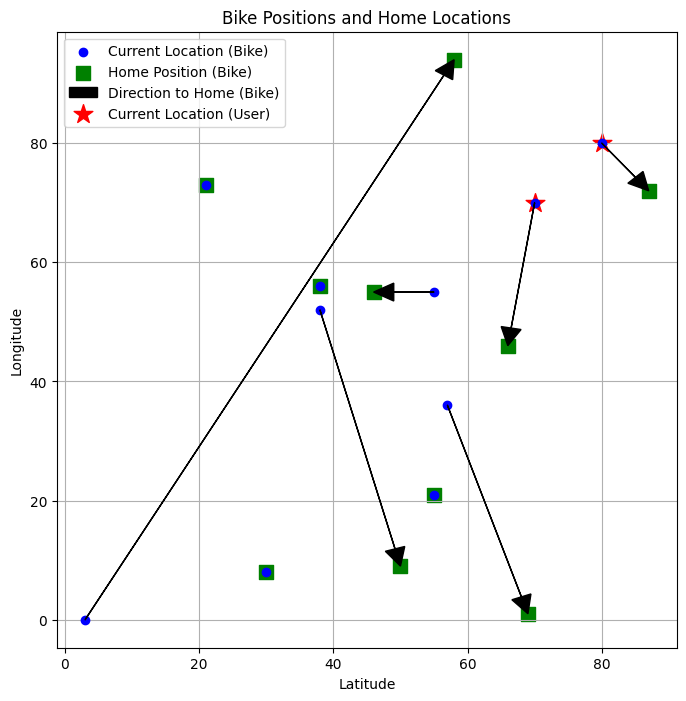

In [ ]:
import matplotlib.pyplot as plt

# プロットを作成
plt.figure(figsize=(8, 8))

# 自転車と自宅位置のプロット
for index, row in df_bikes.iterrows():
    # 現在地をプロット
    plt.scatter(row['Current Location'][0], row['Current Location'][1],
                marker='o', color='blue', zorder=2,
                label="Current Location (Bike)" if index == 0 else "")
    # 自宅位置をプロット
    plt.scatter(row['Home Position'][0], row['Home Position'][1],
                marker='s', color='green', s=100, zorder=1,
                label="Home Position (Bike)" if index == 0 else "")
    # 矢印をプロット
    # 見やすさの観点から矢印の長さを短くしてプロット
    plt.arrow(row['Current Location'][0], row['Current Location'][1],
              row['Home Position'][0] - row['Current Location'][0],
              row['Home Position'][1] - row['Current Location'][1],
              head_width=3, head_length=3, fc='black', ec='black',
              length_includes_head=True, zorder=3,
              label="Direction to Home (Bike)" if index == 0 else "")

# ユーザーの位置と目的地のプロット
for index, row in df_users.iterrows():
    # 現在地をプロット
    plt.scatter(row['Current Position'][0], row['Current Position'][1],
                marker='*', color='red', s=200, zorder=1,
                label="Current Location (User)" if index == 0 else "")

# y軸をLatitudeに設定
plt.xlabel('Latitude')
# x軸をLongitudeに設定
plt.ylabel('Longitude')
plt.title('Bike Positions and Home Locations')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print("移動後の自転車のノルムの総和:", calculate_total_distance(df_bikes))

移動後の自転車のノルムの総和: 234.5124427440561
